In [29]:
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import *
from keras.applications.efficientnet import *
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, regularizers
from keras.applications.vgg19 import *
from keras.applications.resnet import *
from keras.applications.efficientnet import *
from keras.applications.vgg16 import *
from keras.applications.densenet import *
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import warnings

In [30]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_dimension = (224, 224)
epochs = 100
batch_size = 32
epoch_index = [i for i in range(1, epochs + 1)]

#### Check whether GPU is available

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [32]:
labels = {"glioma": 1, "meningioma": 2, "notumor": 0, "pituitary": 3}
dir_name = "MRI_DATA"
image_list = list()
truth_list = list()

for label, index in labels.items():
    path = os.path.join("Brain_MRI_data2", dir_name, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_list.append(current_image)
        truth_list.append(index)

features = np.array(image_list) / 255.0  # rescale
labels = tf.keras.utils.to_categorical(truth_list)

100%|██████████| 2658/2658 [00:02<00:00, 925.54it/s] 


In [107]:
labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [33]:
print("image dimension: {}, label dimension: {}".format(features.shape, labels.shape))

image dimension: (10287, 224, 224, 3), label dimension: (10287, 4)


#### Define Models

In [34]:
def simple_cnn():
    model_simple_cnn = models.Sequential()
    model_simple_cnn.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
    model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_simple_cnn.add(layers.Conv2D(32, 3, activation='relu'))
    model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_simple_cnn.add(layers.Conv2D(64, 3, activation='relu'))
    model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_simple_cnn.add(layers.Flatten())
    model_simple_cnn.add(layers.Dense(256, activation='softmax'))
    model_simple_cnn.add(layers.Dropout(0.5))
    model_simple_cnn.add(layers.Dense(4, activation='softmax'))
    return model_simple_cnn


def resnet_50():
    base_resnet50 = ResNet50()
    model_resnet = models.Sequential()
    model_resnet.add(base_resnet50)
    model_resnet.add(layers.Input(shape=(224, 224, 3)))
    model_resnet.add(layers.Flatten())
    model_resnet.add(layers.Dense(256, activation='relu'))
    model_resnet.add(layers.Dropout(0.5))
    model_resnet.add(layers.Dense(4, activation='softmax'))
    return model_resnet


def vgg_16():
    base_vgg16 = VGG16(input_shape=(224, 224, 3))
    model_vgg16 = models.Sequential()
    model_vgg16.add(base_vgg16)
    model_vgg16.add(layers.Flatten())
    model_vgg16.add(layers.Dense(128, activation='relu'))
    model_vgg16.add(layers.Dropout(0.5))
    model_vgg16.add(layers.Dense(4, activation='softmax'))
    return model_vgg16


def vgg_19():
    base_vgg19 = VGG19(input_shape=(224, 224, 3))
    model_vgg19 = models.Sequential()
    model_vgg19.add(base_vgg19)
    model_vgg19.add(layers.Flatten())
    model_vgg19.add(layers.Dense(128, kernel_regularizer='l2', activation='relu'))
    model_vgg19.add(layers.Dropout(0.5))
    model_vgg19.add(layers.Dense(4, activation='softmax'))
    return model_vgg19


def efficientnet(base_model):
    base_efficientnet = base_model
    model_efficientnet = models.Sequential()
    model_efficientnet.add(base_efficientnet)
    model_efficientnet.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    model_efficientnet.add(layers.Dropout(0.5))
    model_efficientnet.add(layers.Dense(4, activation='softmax'))
    return model_efficientnet


def densenet(base_model):
    model_densenet = models.Sequential()
    model_densenet.add(base_model)
    model_densenet.add(layers.AveragePooling2D(pool_size=(3, 3), name='avg_pool'))
    model_densenet.add(layers.Flatten())
    model_densenet.add(layers.Dense(128, activation='relu'))
    model_densenet.add(layers.Dropout(0.5))
    model_densenet.add(layers.Dense(4, activation='softmax'))
    return model_densenet

def resnet_152():
    base_resnet152 = ResNet152()
    model_resnet = models.Sequential()
    model_resnet.add(base_resnet152)
    model_resnet.add(layers.Input(shape=(224, 224, 3)))
    model_resnet.add(layers.Flatten())
    model_resnet.add(layers.Dense(256, activation='relu'))
    model_resnet.add(layers.Dropout(0.5))
    model_resnet.add(layers.Dense(4, activation='softmax'))
    return model_resnet

#### Define model saving function, learning rate function, early stop function

In [35]:
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    monitor='val_accuracy',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='max')
    return [checkpoint]



#### Split dataset into train, validation and test set

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, shuffle=True)
train_generator = ImageDataGenerator(validation_split=0.25)
test_generator = ImageDataGenerator()

train_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="training")
validation_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="validation", seed=42)
test_df = train_generator.flow(X_test, y_test, batch_size=batch_size)

#### Use a simple CNN

In [37]:
simple_cnn_path = "simple_cnn.hdf5"
model_simple_cnn = simple_cnn()
model_simple_cnn.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model_simple_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

In [10]:
simple_cnn_history = model_simple_cnn.fit(train_df,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_data=validation_df,
                                          callbacks=save_model(simple_cnn_path))

Epoch 1/100
181/181 [==============================] - 10s 20ms/step - loss: 1.3400 - accuracy: 0.3373 - val_loss: 1.3115 - val_accuracy: 0.4295

Epoch 00001: val_accuracy improved from -inf to 0.42946, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 2/100
181/181 [==============================] - 3s 17ms/step - loss: 1.3058 - accuracy: 0.3530 - val_loss: 1.2716 - val_accuracy: 0.5047

Epoch 00002: val_accuracy improved from 0.42946 to 0.50467, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 3/100
181/181 [==============================] - 3s 17ms/step - loss: 1.2903 - accuracy: 0.3489 - val_loss: 1.2667 - val_accuracy: 0.4295

Epoch 00003: val_accuracy did not improve from 0.50467
Epoch 4/100
181/181 [==============================] - 3s 17ms/step - loss: 1.2779 - accuracy: 0.3530 - val_loss: 1.2333 - val_accuracy: 0.4793

Epoch 00004: val_accuracy did not improve from 0.50467
Epoch 5/100
181/181 [==============================] - 3s 17ms/step - loss: 1.2500 -

In [38]:
model_simple_cnn.load_weights(os.path.join("trained_model_weights", simple_cnn_path))
model_simple_cnn.evaluate(test_df)

2023-02-23 22:29:45.145888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 5s 35ms/step - loss: 0.1704 - accuracy: 0.9693


[0.1703958362340927, 0.9692845940589905]

Text(0.5, 1.0, 'Simple CNN Model')

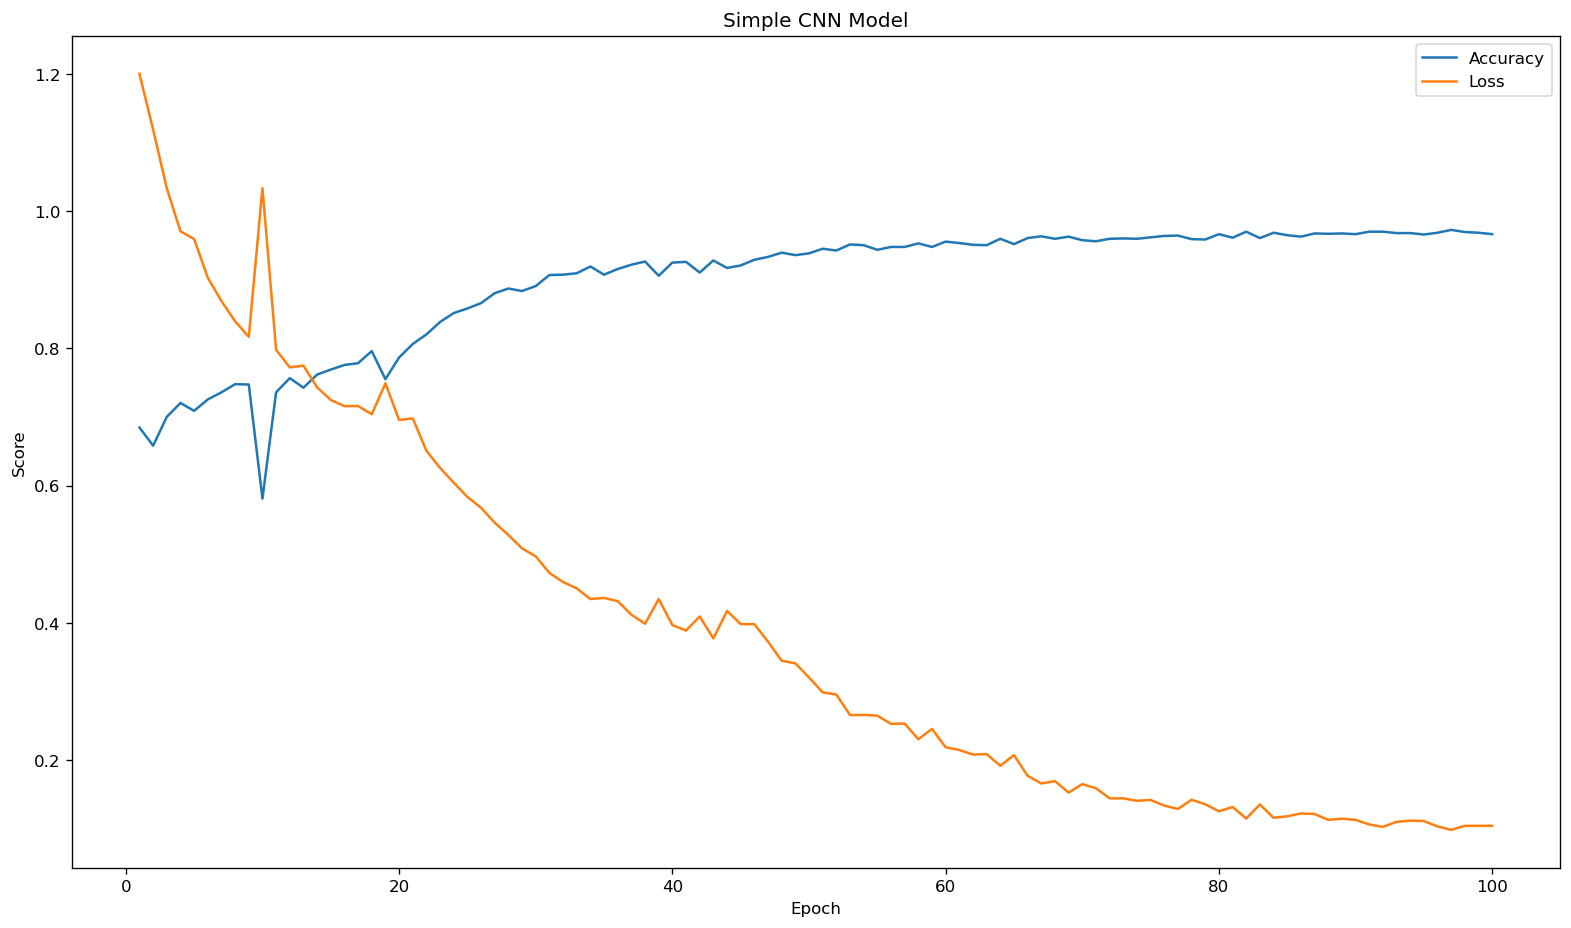

In [11]:
simple_cnn_result = pd.DataFrame({"Accuracy": simple_cnn_history.history["val_accuracy"],
                                  "Loss": simple_cnn_history.history["val_loss"]}, index=epoch_index)
simple_cnn_result.to_csv("Simple_CNN_result.csv")
ax_simple_cnn = simple_cnn_result.plot.line(figsize=(16, 9))
ax_simple_cnn.set_xlabel("Epoch")
ax_simple_cnn.set_ylabel("Score")
ax_simple_cnn.set_title("Simple CNN Model")

#### Using Resnet50

In [45]:
model_resnet_path = "resnet50.hdf5"
model_resnet = resnet_50()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 input_11 (InputLayer)       multiple                  0         
                                                                 
 flatten_8 (Flatten)         (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               256256    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 25,893,996
Trainable params: 25,840,876


In [13]:
model_resnet_history = model_resnet.fit(train_df,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=validation_df,
                                        callbacks=save_model(model_resnet_path))

Epoch 1/100
181/181 [==============================] - 27s 117ms/step - loss: 1.3661 - accuracy: 0.5412 - val_loss: 1.3846 - val_accuracy: 0.4009

Epoch 00001: val_accuracy improved from -inf to 0.40093, saving model to trained_model_weights\resnet50.hdf5
Epoch 2/100
181/181 [==============================] - 19s 103ms/step - loss: 1.3176 - accuracy: 0.7728 - val_loss: 1.3811 - val_accuracy: 0.2614

Epoch 00002: val_accuracy did not improve from 0.40093
Epoch 3/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2761 - accuracy: 0.8885 - val_loss: 1.3719 - val_accuracy: 0.2910

Epoch 00003: val_accuracy did not improve from 0.40093
Epoch 4/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2392 - accuracy: 0.9438 - val_loss: 1.3343 - val_accuracy: 0.5161

Epoch 00004: val_accuracy improved from 0.40093 to 0.51608, saving model to trained_model_weights\resnet50.hdf5
Epoch 5/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2

Text(0.5, 1.0, 'Resnet50 Model')

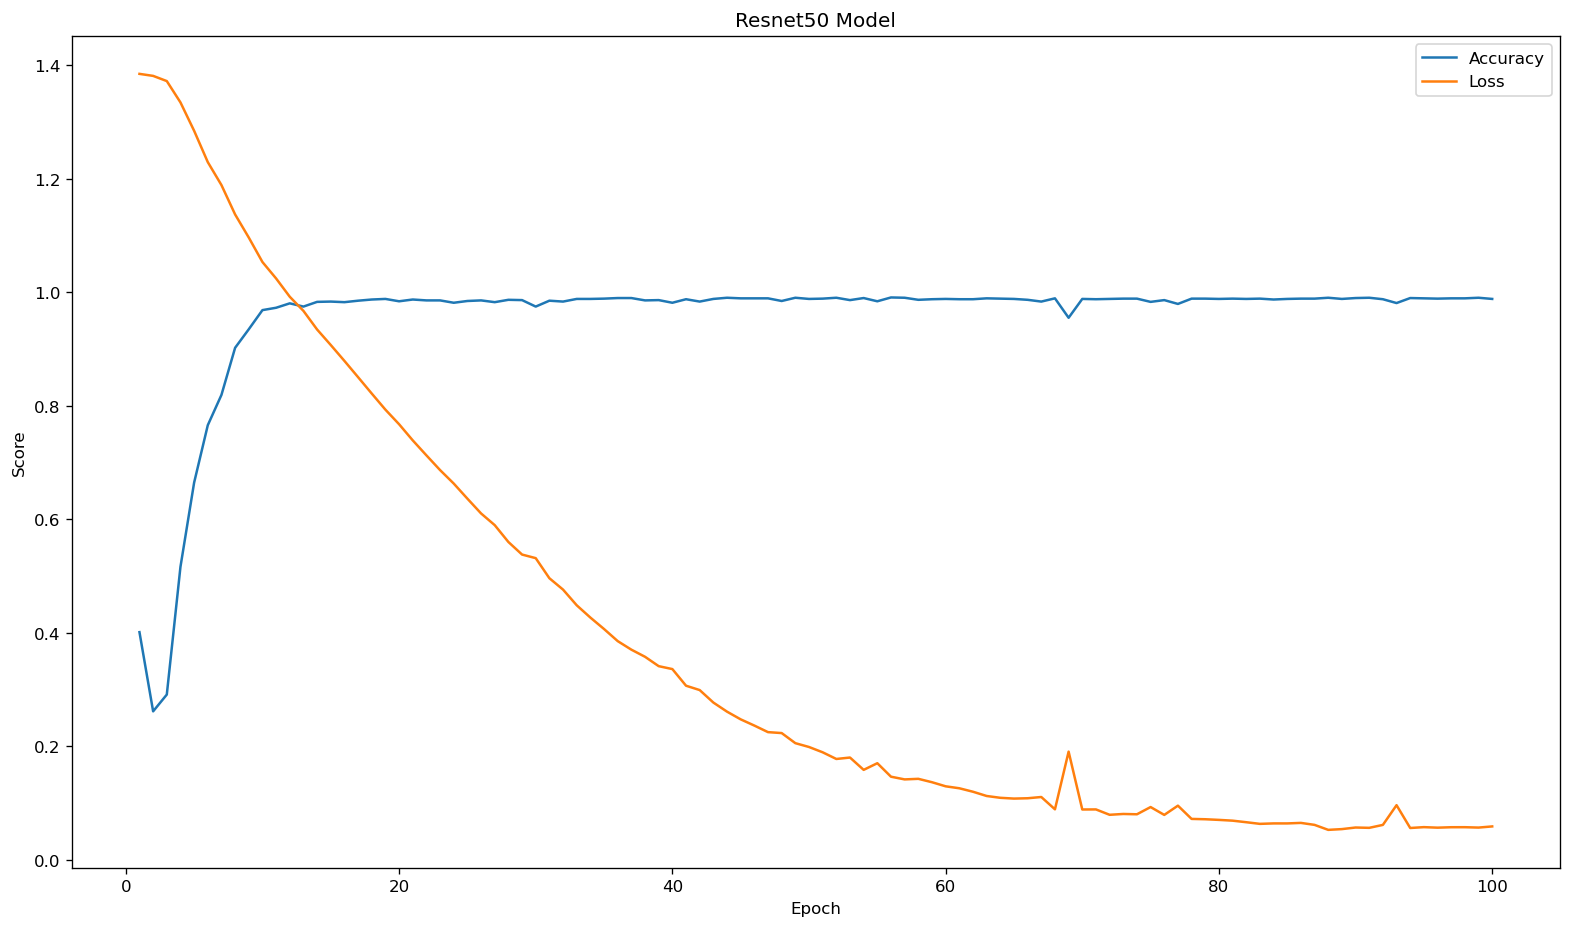

In [14]:
epoch_index = [i for i in range(1, epochs + 1)]
resnet_result = pd.DataFrame({"Accuracy": model_resnet_history.history["val_accuracy"],
                              "Loss": model_resnet_history.history["val_loss"]}, index=epoch_index)
resnet_result.to_csv("resnet_result.csv")
ax_resnet = resnet_result.plot.line(figsize=(16, 9))
ax_resnet.set_xlabel("Epoch")
ax_resnet.set_ylabel("Score")
ax_resnet.set_title("Resnet50 Model")

In [50]:
model_resnet.load_weights(os.path.join("trained_model_weights", model_resnet_path))
model_resnet.evaluate(test_df)

81/81 [==============================] - 11s 137ms/step - loss: 0.1439 - accuracy: 0.9911


[0.14389005303382874, 0.9910575747489929]

#### Using VGG-16

In [51]:
model_vgg16_path = "vgg16.hdf5"
model_vgg16 = vgg_16()
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten_9 (Flatten)         (None, 1000)              0         
                                                                 
 dense_19 (Dense)            (None, 128)               128128    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 4)                 516       
                                                                 
Total params: 138,486,188
Trainable params: 138,486,188
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_vgg16_history = model_vgg16.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg16_path))

Epoch 1/100
181/181 [==============================] - 33s 148ms/step - loss: 1.3606 - accuracy: 0.3987 - val_loss: 1.3494 - val_accuracy: 0.4793

Epoch 00001: val_accuracy improved from -inf to 0.47925, saving model to trained_model_weights\vgg16.hdf5
Epoch 2/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3399 - accuracy: 0.6069 - val_loss: 1.3307 - val_accuracy: 0.8662

Epoch 00002: val_accuracy improved from 0.47925 to 0.86618, saving model to trained_model_weights\vgg16.hdf5
Epoch 3/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3205 - accuracy: 0.7555 - val_loss: 1.3124 - val_accuracy: 0.8942

Epoch 00003: val_accuracy improved from 0.86618 to 0.89419, saving model to trained_model_weights\vgg16.hdf5
Epoch 4/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3026 - accuracy: 0.8358 - val_loss: 1.2939 - val_accuracy: 0.9201

Epoch 00004: val_accuracy improved from 0.89419 to 0.92012, saving model to trained_mode

Text(0.5, 1.0, 'VGG16 Model')

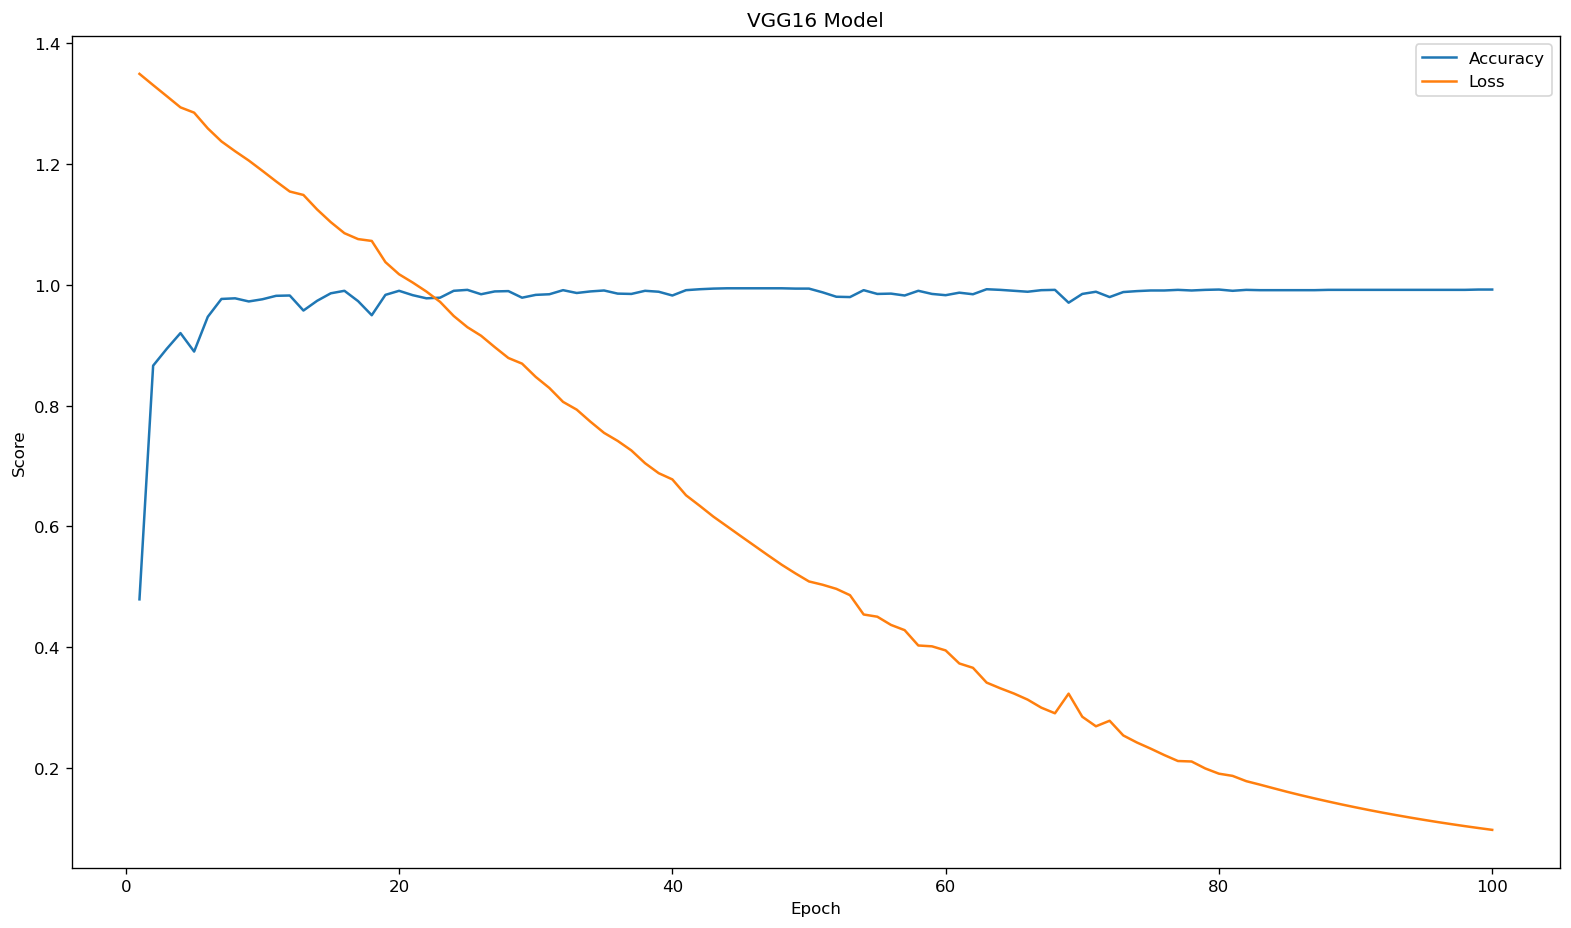

In [18]:
vgg16_result = pd.DataFrame({"Accuracy": model_vgg16_history.history["val_accuracy"],
                             "Loss": model_vgg16_history.history["val_loss"]}, index=epoch_index)
vgg16_result.to_csv("vgg16_result.csv")
ax_vgg16 = vgg16_result.plot.line(figsize=(16, 9))
ax_vgg16.set_xlabel("Epoch")
ax_vgg16.set_ylabel("Score")
ax_vgg16.set_title("VGG16 Model")

In [52]:
model_vgg16.load_weights(os.path.join("trained_model_weights", model_vgg16_path))
model_vgg16.evaluate(test_df)

2023-02-23 22:38:26.541369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 20s 239ms/step - loss: 0.6040 - accuracy: 0.9907


[0.6040382385253906, 0.990668773651123]

#### Using VGG-19

In [53]:
model_vgg19_path = "vgg19.hdf5"
model_vgg19 = vgg_19()
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
 flatten_10 (Flatten)        (None, 1000)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               128128    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 4)                 516       
                                                                 
Total params: 143,795,884
Trainable params: 143,795,884
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_vgg19_history = model_vgg19.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg19_path))

Epoch 1/100
181/181 [==============================] - 27s 143ms/step - loss: 1.3670 - accuracy: 0.4194 - val_loss: 1.3587 - val_accuracy: 0.6043

Epoch 00001: val_accuracy improved from -inf to 0.60425, saving model to trained_model_weights\vgg19.hdf5
Epoch 2/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3506 - accuracy: 0.4731 - val_loss: 1.3451 - val_accuracy: 0.4927

Epoch 00002: val_accuracy did not improve from 0.60425
Epoch 3/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3412 - accuracy: 0.4795 - val_loss: 1.3354 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.60425
Epoch 4/100
181/181 [==============================] - 26s 143ms/step - loss: 1.3346 - accuracy: 0.4847 - val_loss: 1.3280 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.60425
Epoch 5/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3274 - accuracy: 0.4806 - val_loss: 1.3224 - val_accuracy: 0.

Text(0.5, 1.0, 'VGG16 Model')

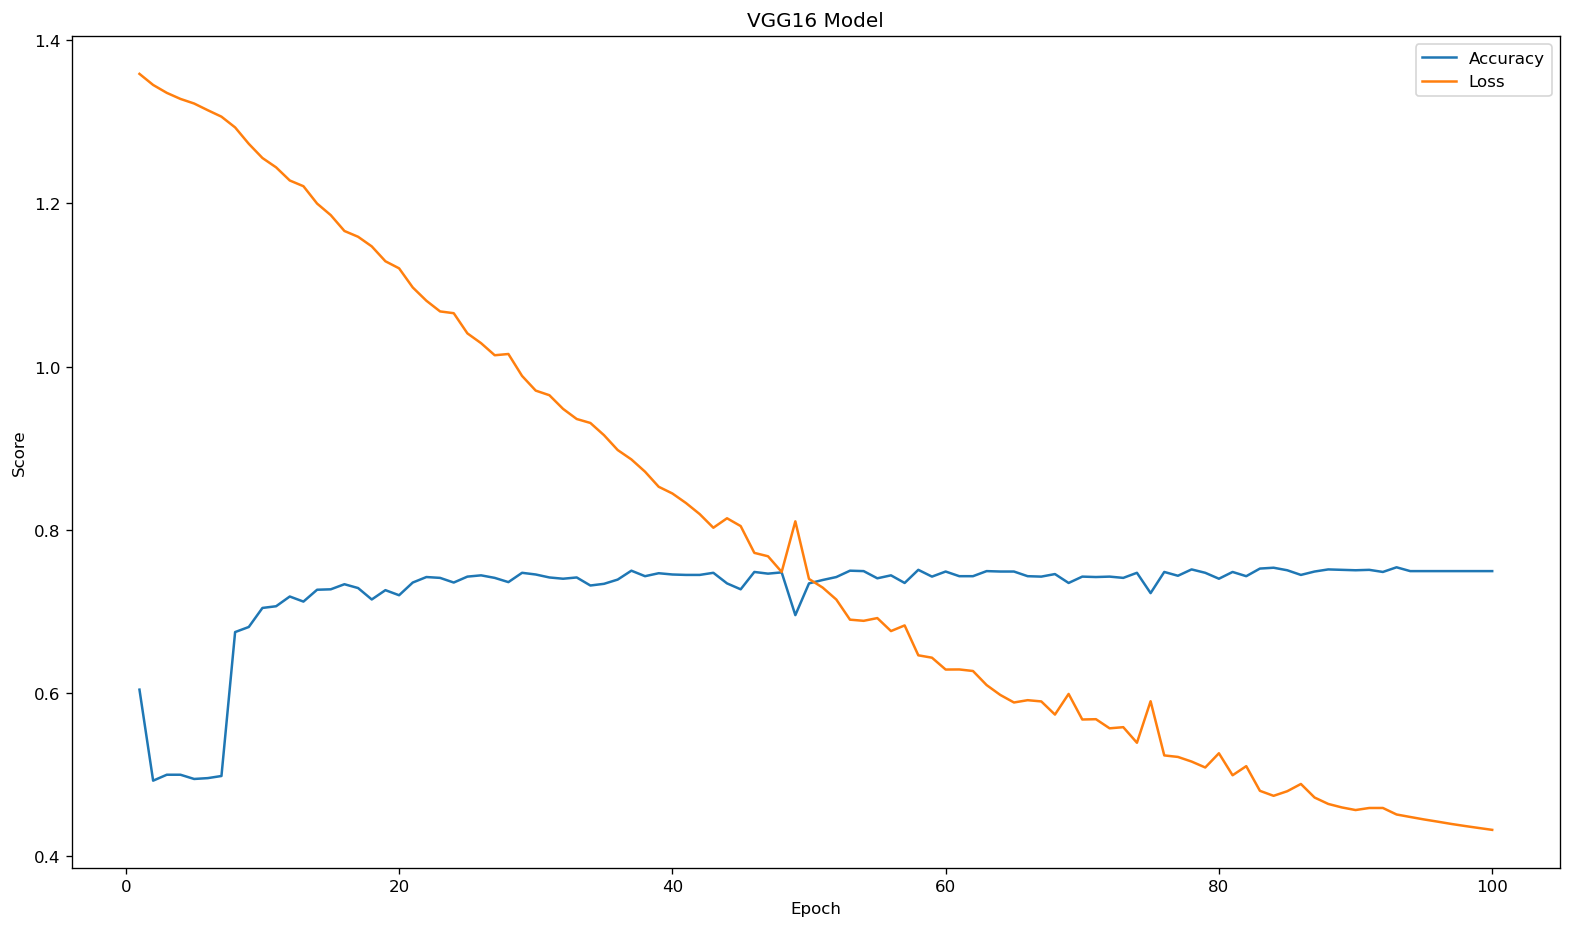

In [22]:
vgg19_result = pd.DataFrame({"Accuracy": model_vgg19_history.history["val_accuracy"],
                             "Loss": model_vgg19_history.history["val_loss"]}, index=epoch_index)
vgg19_result.to_csv("vgg19_result.csv")
ax_vgg19 = vgg19_result.plot.line(figsize=(16, 9))
ax_vgg19.set_xlabel("Epoch")
ax_vgg19.set_ylabel("Score")
ax_vgg19.set_title("VGG16 Model")

In [54]:
model_vgg19.load_weights(os.path.join("trained_model_weights", model_vgg19_path))
model_vgg19.evaluate(test_df)

2023-02-23 22:38:59.199519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 25s 292ms/step - loss: 2.8012 - accuracy: 0.7414


[2.801168203353882, 0.7414463758468628]

#### Using efficientnet B0

In [55]:
model_efficientnetB3_path = "efficientnetB3.hdf5"
base_efficientnet = EfficientNetB3(include_top=False, weights="imagenet", pooling="max")
model_efficientnetB3 = efficientnet(base_efficientnet)
model_efficientnetB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
model_efficientnetB3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 1536)              0         
                                                                 
 dense_23 (Dense)            (None, 4)                 6148      
                                                                 
Total params: 10,795,827
Trainable params: 10,705,452
Non-trainable params: 90,375
_________________________________________________________________


In [15]:
model_efficientnetB3_history = model_efficientnetB3.fit(train_df,
                                                        verbose=1,
                                                        epochs=epochs,
                                                        validation_data=validation_df,
                                                        callbacks=save_model(model_efficientnetB3_path))

Epoch 1/100
181/181 [==============================] - 82s 375ms/step - loss: 1.4023 - accuracy: 0.5201 - val_loss: 5.2184 - val_accuracy: 0.2293

Epoch 00001: val_accuracy improved from -inf to 0.22925, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 2/100
181/181 [==============================] - 45s 248ms/step - loss: 0.8755 - accuracy: 0.7031 - val_loss: 1.8033 - val_accuracy: 0.3532

Epoch 00002: val_accuracy improved from 0.22925 to 0.35322, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 3/100
181/181 [==============================] - 45s 249ms/step - loss: 0.6941 - accuracy: 0.7731 - val_loss: 3.0428 - val_accuracy: 0.2407

Epoch 00003: val_accuracy did not improve from 0.35322
Epoch 4/100
181/181 [==============================] - 46s 255ms/step - loss: 0.6166 - accuracy: 0.7888 - val_loss: 2.3164 - val_accuracy: 0.3543

Epoch 00004: val_accuracy improved from 0.35322 to 0.35425, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 

Text(0.5, 1.0, 'efficientnetB3 Model')

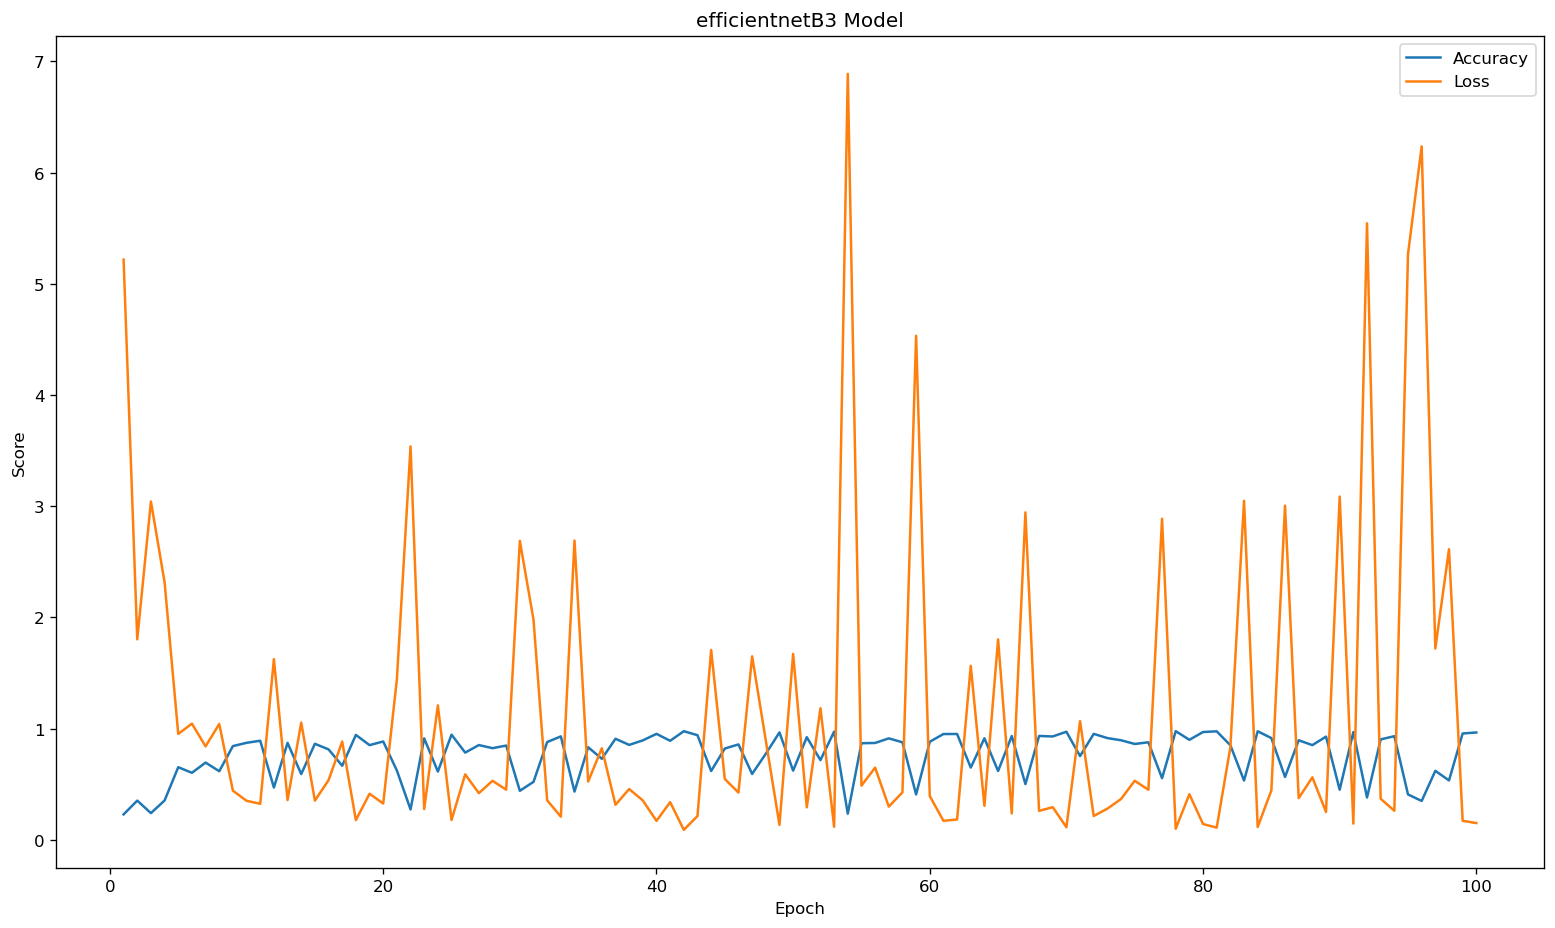

In [17]:
efficientnetB3_result = pd.DataFrame({"Accuracy": model_efficientnetB3_history.history["val_accuracy"],
                                      "Loss": model_efficientnetB3_history.history["val_loss"]}, index=epoch_index)
efficientnetB3_result.to_csv("efficientnetB3_result.csv")
ax_efficientnetB3 = efficientnetB3_result.plot.line(figsize=(16, 9))
ax_efficientnetB3.set_xlabel("Epoch")
ax_efficientnetB3.set_ylabel("Score")
ax_efficientnetB3.set_title("efficientnetB3 Model")

In [56]:
model_efficientnetB3.load_weights(os.path.join("trained_model_weights", model_efficientnetB3_path))
model_efficientnetB3.evaluate(test_df)

2023-02-23 22:39:35.691262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 21s 193ms/step - loss: 369149.3438 - accuracy: 0.2484


[369149.34375, 0.2484447956085205]

#### Using DenseNet121

In [57]:
model_densenet121_path = "model_densenet121.hdf5"
model_densenet121 = densenet(DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3)))
model_densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
model_densenet121.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 avg_pool (AveragePooling2D)  (None, 2, 2, 1024)       0         
                                                                 
 flatten_11 (Flatten)        (None, 4096)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               524416    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 4)                 516       
                                                                 
Total params: 7,562,436
Trainable params: 7,478,788
N

In [24]:
model_densenet121_history = model_densenet121.fit(train_df,
                                                  verbose=1,
                                                  epochs=epochs,
                                                  validation_data=validation_df,
                                                  callbacks=save_model(model_densenet121_path))

Epoch 1/100
181/181 [==============================] - 39s 149ms/step - loss: 1.0080 - accuracy: 0.5860 - val_loss: 1.5591 - val_accuracy: 0.2495

Epoch 00001: val_accuracy improved from -inf to 0.24948, saving model to trained_model_weights\model_densenet121.hdf5
Epoch 2/100
181/181 [==============================] - 22s 121ms/step - loss: 0.7219 - accuracy: 0.7315 - val_loss: 2.2114 - val_accuracy: 0.2962

Epoch 00002: val_accuracy improved from 0.24948 to 0.29616, saving model to trained_model_weights\model_densenet121.hdf5
Epoch 3/100
181/181 [==============================] - 22s 122ms/step - loss: 0.6145 - accuracy: 0.7748 - val_loss: 1.7446 - val_accuracy: 0.3978

Epoch 00003: val_accuracy improved from 0.29616 to 0.39782, saving model to trained_model_weights\model_densenet121.hdf5
Epoch 4/100
181/181 [==============================] - 22s 122ms/step - loss: 0.5083 - accuracy: 0.8213 - val_loss: 0.8067 - val_accuracy: 0.6623

Epoch 00004: val_accuracy improved from 0.39782 to 0

Text(0.5, 1.0, 'densenet121 Model')

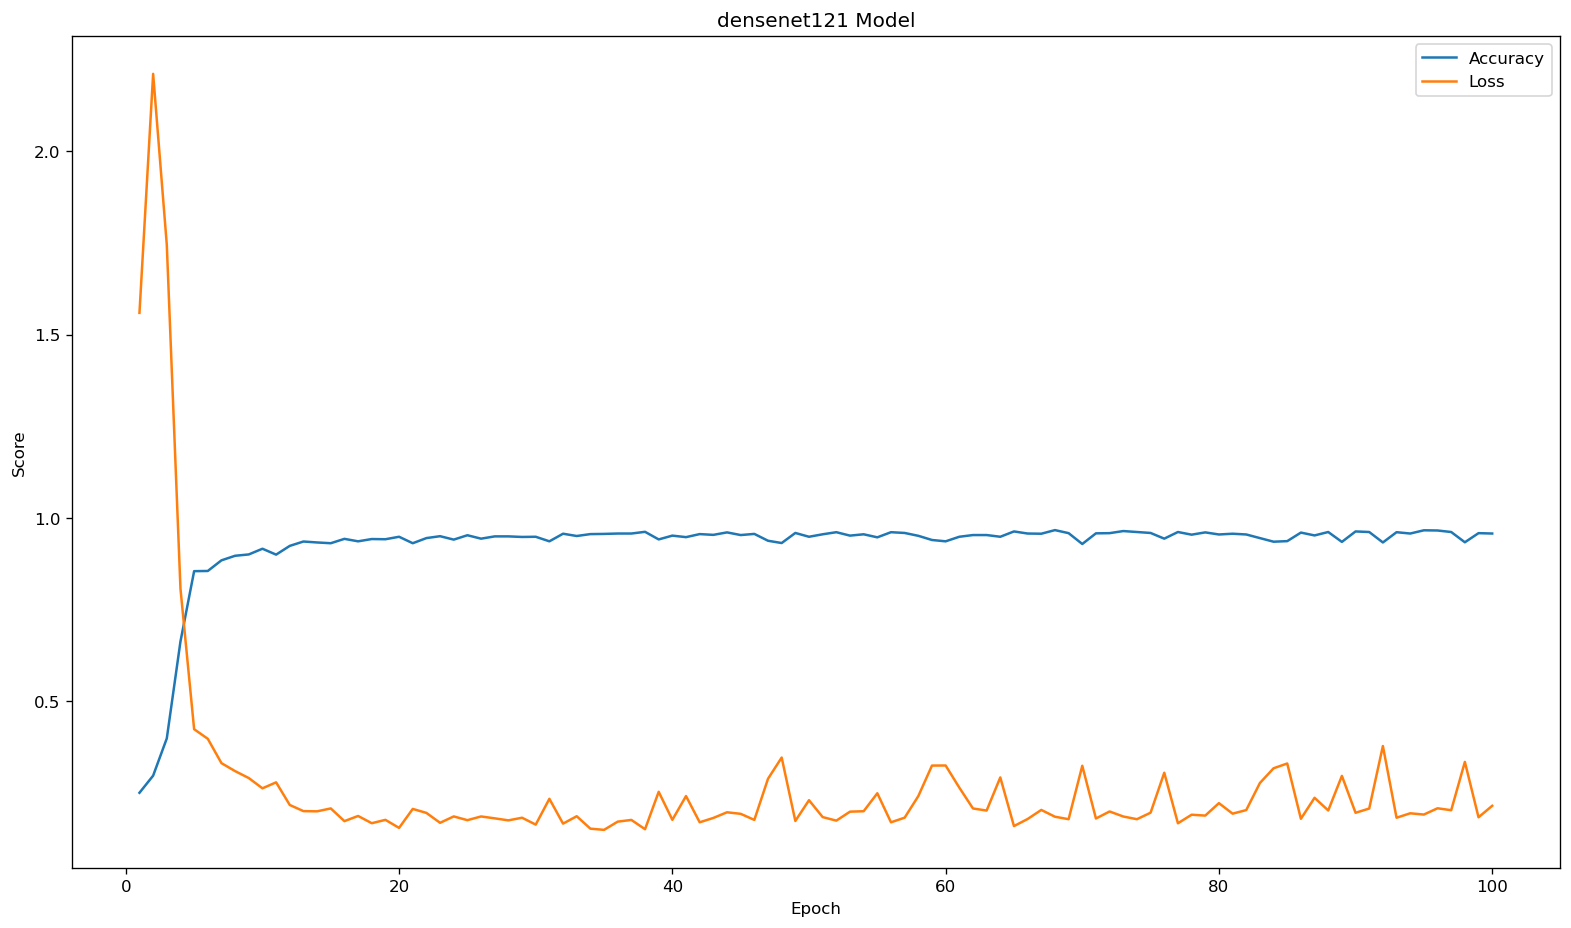

In [26]:
densenet121_result = pd.DataFrame({"Accuracy": model_densenet121_history.history["val_accuracy"],
                                   "Loss": model_densenet121_history.history["val_loss"]}, index=epoch_index)
densenet121_result.to_csv("densenet121_result.csv")
ax_densenet121 = densenet121_result.plot.line(figsize=(16, 9))
ax_densenet121.set_xlabel("Epoch")
ax_densenet121.set_ylabel("Score")
ax_densenet121.set_title("densenet121 Model")

In [58]:
model_densenet121.load_weights(os.path.join("trained_model_weights", model_densenet121_path))
model_densenet121.evaluate(test_df)

2023-02-23 22:40:34.937335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 15s 144ms/step - loss: 0.0717 - accuracy: 0.9876


[0.07168073207139969, 0.9875583648681641]

#### Using Densenet 201

In [59]:
model_densenet201_path = "model_densenet201.hdf5"
model_densenet201 = densenet(DenseNet201(weights=None, include_top=False, input_shape=(224, 224, 3)))
model_densenet201.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
model_densenet201.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 avg_pool (AveragePooling2D)  (None, 2, 2, 1920)       0         
                                                                 
 flatten_12 (Flatten)        (None, 7680)              0         
                                                                 
 dense_26 (Dense)            (None, 128)               983168    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 516       
                                                                 
Total params: 19,305,668
Trainable params: 19,076,612

In [ ]:
model_densenet201_history = model_densenet201.fit(train_df,
                                                  verbose=1,
                                                  epochs=epochs,
                                                  validation_data=validation_df,
                                                  callbacks=save_model(model_densenet201_path))

In [ ]:
densenet201_result = pd.DataFrame({"Accuracy": model_densenet201_history.history["val_accuracy"],
                                   "Loss": model_densenet201_history.history["val_loss"]}, index=epoch_index)
densenet201_result.to_csv("densenet121_result.csv")
ax_densenet201 = densenet201_result.plot.line(figsize=(16, 9))
ax_densenet201.set_xlabel("Epoch")
ax_densenet201.set_ylabel("Score")
ax_densenet201.set_title("densenet201 Model")

In [60]:
model_densenet201.load_weights(os.path.join("trained_model_weights", model_densenet201_path))
model_densenet201.evaluate(test_df)

2023-02-23 22:41:01.046379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 33s 341ms/step - loss: 0.0955 - accuracy: 0.9844


[0.09551528841257095, 0.9844478964805603]

#### Using ResNet 152

In [62]:
model_resnet_path = "resnet152.hdf5"
model_resnet_152 = resnet_152()
model_resnet_152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_resnet_152.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 1000)              60419944  
                                                                 
 input_20 (InputLayer)       multiple                  0         
                                                                 
 flatten_14 (Flatten)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               256256    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 60,677,228
Trainable params: 60,525,804

In [ ]:
model_resnet_152_history = model_resnet_152.fit(train_df,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=validation_df,
                                        callbacks=save_model(model_resnet_path))

In [63]:
resnet_result = pd.DataFrame({"Accuracy": model_resnet_152_history.history["val_accuracy"],
                              "Loss": model_resnet_152_history.history["val_loss"]}, index=epoch_index)
resnet_result.to_csv("resnet152_result.csv")
ax_resnet = resnet_result.plot.line(figsize=(16, 9))
ax_resnet.set_xlabel("Epoch")
ax_resnet.set_ylabel("Score")
ax_resnet.set_title("Resnet152 Model")

NameError: name 'model_resnet_152_history' is not defined

In [64]:
model_resnet_152.load_weights(os.path.join("trained_model_weights", model_resnet_path))
model_resnet_152.evaluate(test_df)

2023-02-23 22:41:56.760273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 35s 363ms/step - loss: 0.2161 - accuracy: 0.9946


[0.21614257991313934, 0.9945567846298218]

<AxesSubplot: >

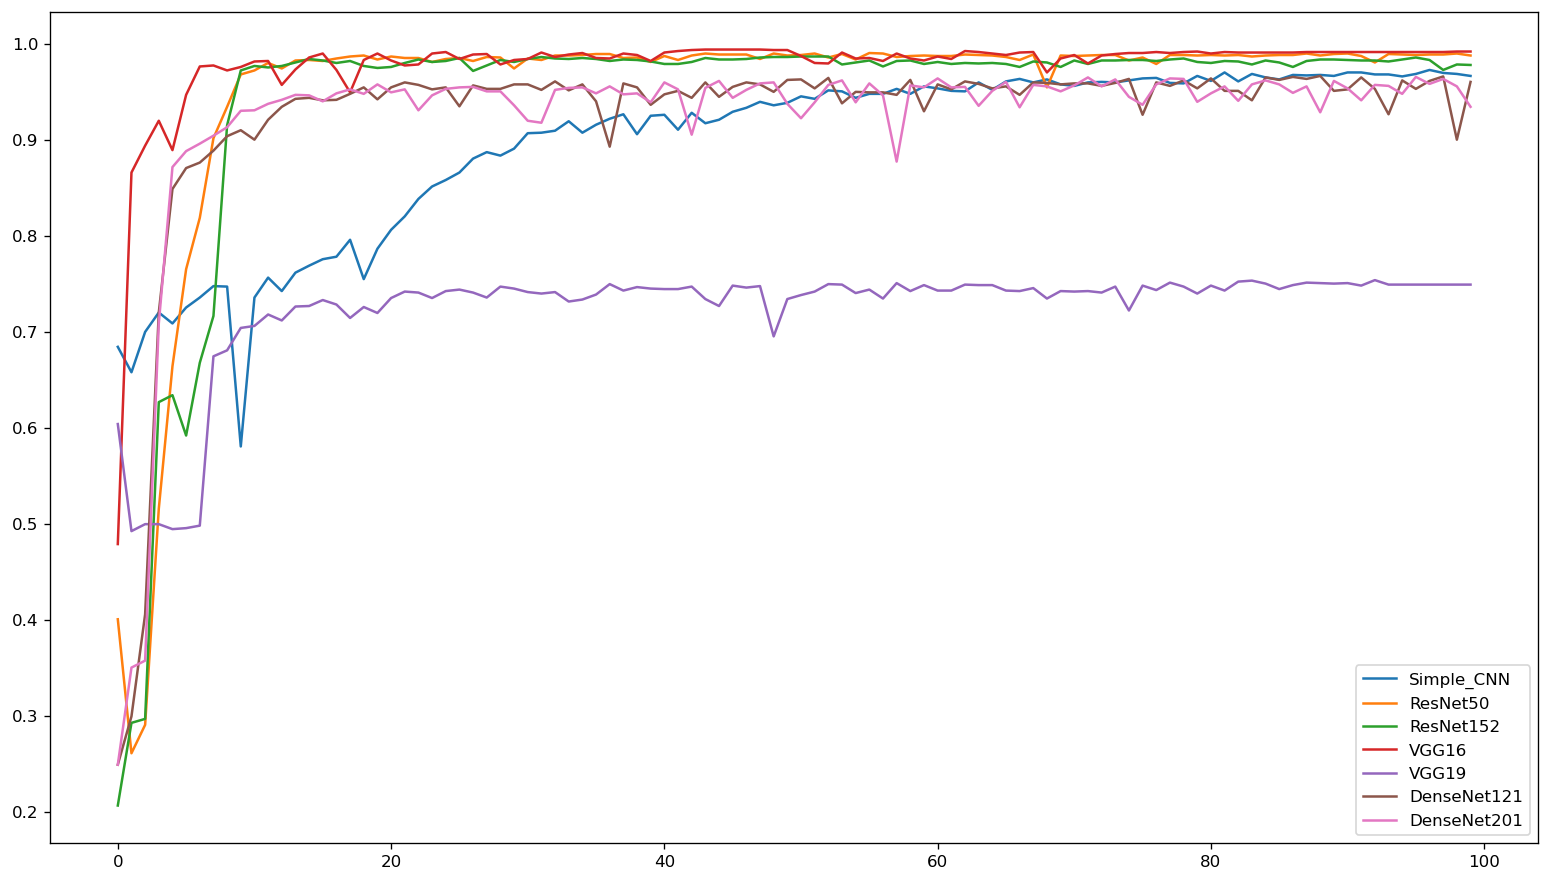

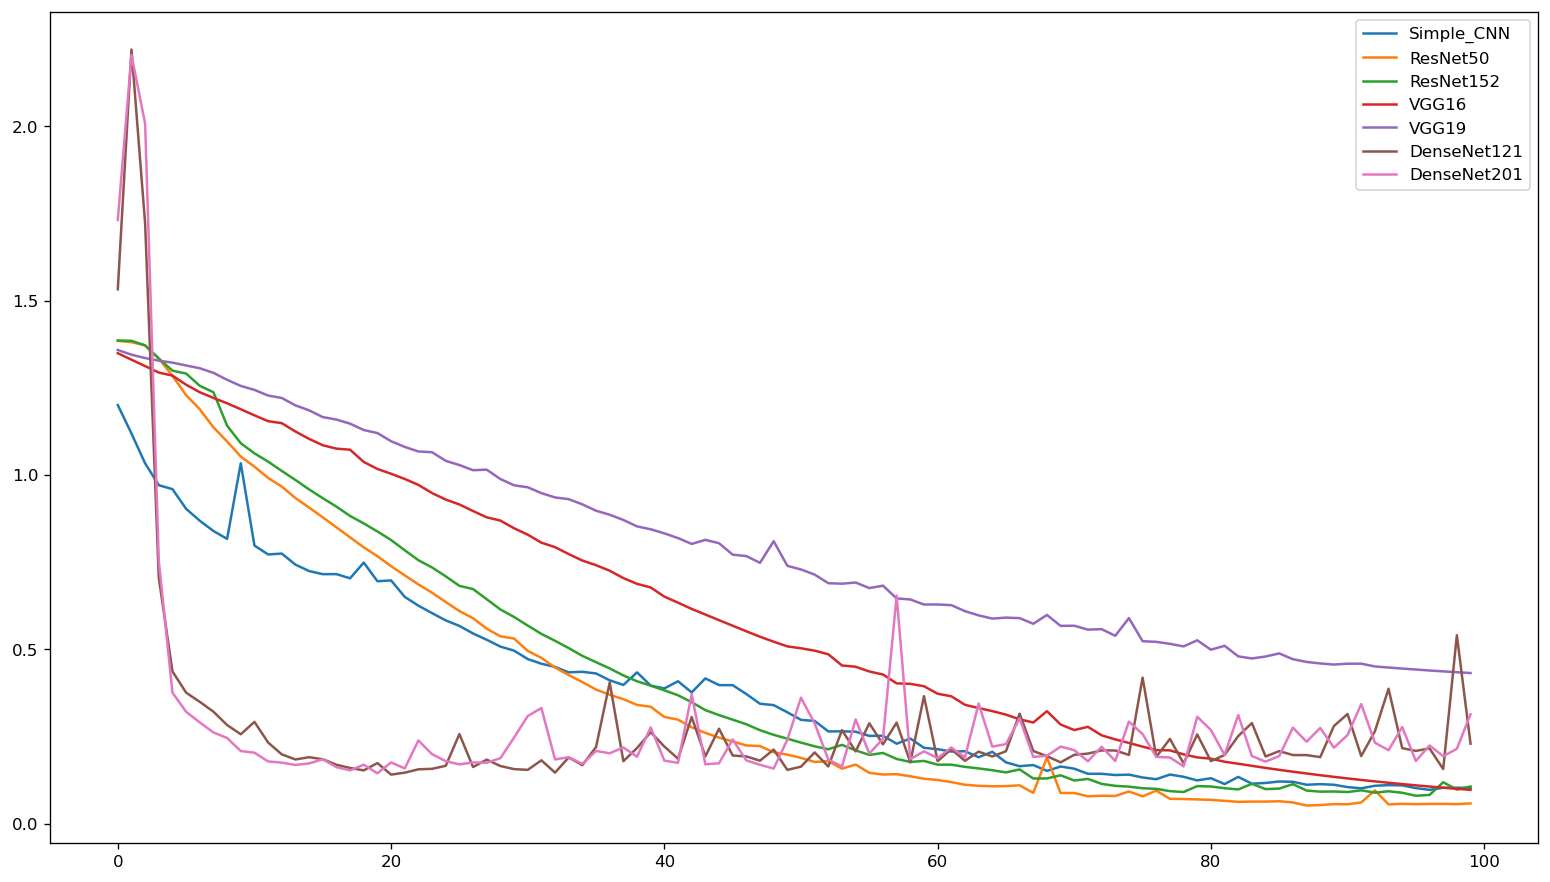

In [23]:
model_accuracy_compare = pd.DataFrame({"Simple_CNN": pd.read_csv("Simple_CNN_result.csv")["Accuracy"],
                                       "ResNet50": pd.read_csv("resnet_result.csv")["Accuracy"],
                                       "ResNet152": pd.read_csv("resnet152_result.csv")["Accuracy"],
                                       "VGG16": pd.read_csv("vgg16_result.csv")["Accuracy"],
                                       "VGG19": pd.read_csv("vgg19_result.csv")["Accuracy"],
                                       # "EfficientNetB3": pd.read_csv("efficientnetB3_result.csv")["Accuracy"],
                                       "DenseNet121": pd.read_csv("densenet121_result.csv")["Accuracy"],
                                       "DenseNet201": pd.read_csv("densenet201_result.csv")["Accuracy"]})

model_accuracy_compare.plot.line(figsize=(16, 9))

model_loss_compare = pd.DataFrame({"Simple_CNN": pd.read_csv("Simple_CNN_result.csv")["Loss"],
                                   "ResNet50": pd.read_csv("resnet_result.csv")["Loss"],
                                   "ResNet152": pd.read_csv("resnet152_result.csv")["Loss"],
                                   "VGG16": pd.read_csv("vgg16_result.csv")["Loss"],
                                   "VGG19": pd.read_csv("vgg19_result.csv")["Loss"],
                                   # "EfficientNetB3": pd.read_csv("efficientnetB3_result.csv")["Loss"],
                                   "DenseNet121": pd.read_csv("densenet121_result.csv")["Loss"],
                                   "DenseNet201": pd.read_csv("densenet201_result.csv")["Loss"]})

model_loss_compare.plot.line(figsize=(16, 9))

In [165]:
def get_predicted(model, test_set):
    predicted_result = list()
    for sample in tqdm(test_set):
        sample = sample.reshape(1, 224,224, 3)
        predicted = np.argmax(model.predict(sample, verbose=False), axis=1)
        predicted_result.append(predicted)
    return predicted_result

predicted_simple_cnn = get_predicted(model_simple_cnn, test_df.x)
predicted_resnet50 = get_predicted(model_resnet, test_df.x)
predicted_resnet152 = get_predicted(model_resnet_152, test_df.x)
predicted_vgg16 = get_predicted(model_vgg16, test_df.x)
predicted_vgg19 = get_predicted(model_vgg19, test_df.x)
predicted_densenet121 = get_predicted(model_densenet121, test_df.x)
predicted_densenet201 = get_predicted(model_densenet201, test_df.x)

y_truth = np.argmax(test_df.y, axis=1)



 32%|███▏      | 822/2572 [01:05<02:20, 12.47it/s]


KeyboardInterrupt: 

In [ ]:
score_df = pd.DataFrame()
def score_results(model, target, predict):
    global score_df
    ac = accuracy_score(target, predict)
    rc = recall_score(target, predict,average='weighted')
    pc = precision_score(target, predict, average='weighted')
    fc = f1_score(target, predict, average='weighted')
    current_df = pd.DataFrame({"Model": [model], "Accuracy": [ac], "Recall": [rc], "Precision": [pc], "F-1": fc})
    score_df = pd.concat([score_df, current_df], ignore_index=True)
    print("{} accuracy score:{}".format(model, ac))
    print("{} recall score:{}".format(model, rc))
    print("{} precision score:{}".format(model, pc))
    print("{} F-1 score:{}".format(model, fc))

In [ ]:
disp_simple_cnn = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_simple_cnn,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_simple_cnn.ax_.set_title("Simple CNN confusion matrix")
score_results("simple CNN", y_truth, predicted_simple_cnn)

In [ ]:
disp_resnet_50 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_resnet50,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_resnet_50.ax_.set_title("ResNet50 confusion matrix")
score_results("ResNet50", y_truth, predicted_simple_cnn)

In [ ]:
disp_resnet_152 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_resnet152,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_resnet_50.ax_.set_title("ResNet152 confusion matrix")
score_results("ResNet152", y_truth, predicted_simple_cnn)

In [ ]:
disp_vgg16 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_vgg16,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_resnet_50.ax_.set_title("VGG16 confusion matrix")
score_results("VGG16", y_truth, predicted_simple_cnn)

In [ ]:
disp_vgg19 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_vgg19,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_resnet_50.ax_.set_title("VGG19 confusion matrix")
score_results("VGG19", y_truth, predicted_simple_cnn)

In [ ]:
disp_densenet121 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_densenet121,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_densenet121.ax_.set_title("DenseNet121 confusion matrix")
score_results("DenseNet121", y_truth, predicted_simple_cnn)

In [ ]:
disp_densenet201 = ConfusionMatrixDisplay.from_predictions(y_true=y_truth,
                                               y_pred=predicted_densenet201,
                                               display_labels=["no tumor", "glioma", "meningioma", "pituitary"],
                                               cmap=plt.cm.Blues)
disp_densenet121.ax_.set_title("DenseNet201 confusion matrix")
score_results("DenseNet201", y_truth, predicted_simple_cnn)

In [ ]:
score_df